# Installs:

In [1]:
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
import matplotlib.pyplot as plt
import torch

2023-12-01 00:17:12,047 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:17:12,051 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:17:12,052 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:17:12,053 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:17:12,081 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:17:12,082 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json


Steps for downloading found: https://torcheeg.readthedocs.io/en/stable/auto_examples/examples_dreamer_tsception.html

Needed to request data from: Download URL: https://zenodo.org/record/546113

Request Accepted: Files uploaded to google drive folder

# Import the dataset:

In [2]:
dataset_path = "./DREAMER.mat"

In [3]:
dataset = DREAMERDataset(io_path='./examples_dreamer_tsception/dreamer',
                          mat_path=dataset_path,
                          offline_transform=transforms.Compose([transforms.BaselineRemoval(), transforms.MeanStdNormalize(), transforms.To2d()]),
                          online_transform=transforms.ToTensor(),
                          label_transform=transforms.Compose([transforms.Select('valence'),transforms.Binary(3.0)]),
                          chunk_size=128,
                          baseline_chunk_size=128,
                          num_baseline=61,
                          num_worker=4)

dataset already exists at path ./examples_dreamer_tsception/dreamer, reading from path...


In [4]:
print(dataset)

DREAMERDataset(
    io_path='./examples_dreamer_tsception/dreamer',
    io_size=10485760,
    io_mode='lmdb',
    in_memory=False,
    mat_path='./DREAMER.mat',
    chunk_size=128,
    overlap=0,
    num_channel=14,
    num_baseline=61,
    baseline_chunk_size=128,
    online_transform=ToTensor(apply_to_baseline=False),
    offline_transform=Compose(
    BaselineRemoval(apply_to_baseline=False),
    MeanStdNormalize(apply_to_baseline=False, mean=None, std=None, axis=None),
    To2d(apply_to_baseline=False)
),
    label_transform=Compose(
    Select(key='valence'),
    Binary(threshold=3.0)
),
    before_trial=None,
    after_trial=None,
    num_worker=4,
    verbose=True
)
length=85744


In [5]:
# print a sample point
# for i in range(4000,4200):  #85050
sample_data, sample_label = dataset[0]
print(sample_data.shape)

# convert sample point to numpy to check dimension
# sample_data = sample_data.numpy()
# print('Sample data shape:', sample_data.shape)

torch.Size([1, 14, 128])


2023-12-01 00:17:12,691 DEBUG MainThread matplotlib.pyplot Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-12-01 00:17:12,693 DEBUG MainThread matplotlib.pyplot Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-12-01 00:17:12,694 DEBUG MainThread matplotlib.font_manager findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-12-01 00:17:12,695 DEBUG MainThread matplotlib.font_manager findfont: score(FontEntry(fname='/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
2023-12-01 00:17:12,695 DEBUG MainThread matplotlib.font_manager findfont: score(FontEntry(fname='/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data/fonts/ttf/cmsy10.ttf', name='cmsy10', style='normal', 

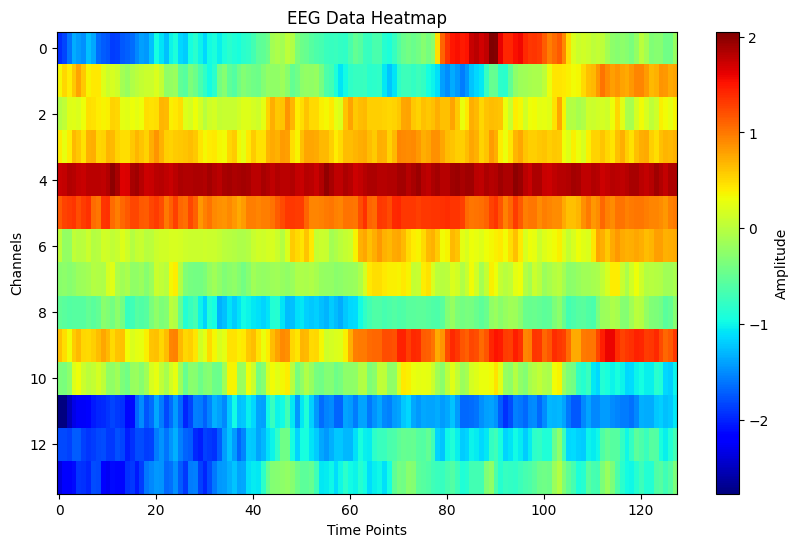

In [6]:
data = sample_data.squeeze(0)

plt.figure(figsize=(10, 6))
plt.imshow(data, aspect='auto', interpolation='nearest', cmap='jet')
plt.colorbar(label='Amplitude')
plt.xlabel('Time Points')
plt.ylabel('Channels')
plt.title('EEG Data Heatmap')
plt.show()

# Define the dataset splits:

In [7]:
from sklearn.model_selection import train_test_split
from torcheeg.model_selection import KFoldGroupbyTrial

# full dataset, 20% of data is reserved for testing
# train_val_dataset, test_dataset = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42)

from torch.utils.data import random_split

# Assuming dataset is an instance of DREAMERDataset
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for testing
test_size = dataset_size - train_size

# Use random_split to split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now train_dataset and test_dataset can be used for training and testing, respectively


In [8]:
NUM_SPLITS = 10

k_fold = KFoldGroupbyTrial(n_splits=NUM_SPLITS, split_path=f'./examples_dreamer_tsception/split')

# TRAINING:

In [9]:
from torch.utils.data import DataLoader
from torcheeg.models import TSCeption

from torcheeg.trainers import ClassifierTrainer
import pytorch_lightning as pl

for i, (train_dataset, val_dataset) in enumerate(k_fold.split(train_dataset)):
  train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=7)
  val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=7)

  model = TSCeption(num_electrodes=14,
                    num_classes=2,
                    num_T=15,
                    num_S=15,
                    in_channels=1,
                    hid_channels=32,
                    sampling_rate=128,
                    dropout=0.5)

  trainer = ClassifierTrainer(model=model,
                              num_classes=2,
                              lr=1e-4,
                              weight_decay=1e-4,
                              accelerator="gpu")
  trainer.fit(train_loader,
              val_loader,
              max_epochs=50,
              default_root_dir=f'./examples_dreamer_tsception/model/{i}',
              callbacks=[pl.callbacks.ModelCheckpoint(save_last=True)],
              enable_progress_bar=True,
              enable_model_summary=True,
              limit_val_batches=0.0)
  score = trainer.test(val_loader,
                        enable_progress_bar=True,
                        enable_model_summary=True)[0]
  print(f'Fold {i} test accuracy: {score["test_accuracy"]:.4f}')

2023-12-01 00:17:14,092 DEBUG MainThread torchaudio._extension Failed to initialize sox extension
Traceback (most recent call last):
  File "/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/torchaudio/_extension/__init__.py", line 60, in <module>
    _init_sox()
  File "/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/torchaudio/_extension/utils.py", line 70, in _init_sox
    _load_lib("libtorchaudio_sox")
  File "/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/torchaudio/_extension/utils.py", line 64, in _load_lib
    torch.ops.load_library(path)
  File "/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/torch/_ops.py", line 852, in load_library
    ctypes.CDLL(path)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/ctypes/__init__.py", line 366, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen(/Users/arnoldcheskis/Library/Python/3.9/lib/pyth

Training: |          | 0/? [00:00<?, ?it/s]

2023-12-01 00:18:12,855 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/0/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-12-01 00:18:12,868 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/0/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.672 train_accuracy: 0.588 



2023-12-01 00:18:14,627 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:18:14,633 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:18:14,634 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:18:14,634 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:18:14,670 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:18:14,671 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:18:16,495 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:18:16,498 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:18:16,498 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:18:16,498 DEBUG Ma


[Train] train_loss: 0.630 train_accuracy: 0.652 



2023-12-01 00:19:31,234 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:19:31,237 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:19:31,237 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:19:31,238 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:19:31,265 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:19:31,267 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:19:32,971 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:19:32,974 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:19:32,975 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:19:32,975 DEBUG Ma


[Train] train_loss: 0.598 train_accuracy: 0.683 



2023-12-01 00:20:49,081 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:20:49,084 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:20:49,084 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:20:49,084 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:20:49,108 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:20:49,109 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:20:50,907 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:20:50,910 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:20:50,910 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:20:50,910 DEBUG Ma


[Train] train_loss: 0.574 train_accuracy: 0.702 



2023-12-01 00:22:08,532 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:22:08,535 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:22:08,535 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:22:08,535 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:22:08,559 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:22:08,560 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:22:10,320 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:22:10,327 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:22:10,328 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:22:10,328 DEBUG Ma


[Train] train_loss: 0.556 train_accuracy: 0.716 



2023-12-01 00:23:27,051 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:23:27,054 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:23:27,054 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:23:27,054 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:23:27,078 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:23:27,079 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:23:28,781 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:23:28,784 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:23:28,784 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:23:28,784 DEBUG Ma


[Train] train_loss: 0.542 train_accuracy: 0.726 



2023-12-01 00:24:45,213 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:24:45,215 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:24:45,216 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:24:45,216 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:24:45,239 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:24:45,240 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:24:47,002 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:24:47,006 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:24:47,007 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:24:47,007 DEBUG Ma


[Train] train_loss: 0.528 train_accuracy: 0.737 



2023-12-01 00:26:03,445 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:26:03,448 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:26:03,448 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:26:03,448 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:26:03,473 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:26:03,474 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:26:05,311 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:26:05,314 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:26:05,315 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:26:05,315 DEBUG Ma


[Train] train_loss: 0.519 train_accuracy: 0.741 



2023-12-01 00:27:21,437 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:27:21,440 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:27:21,440 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:27:21,440 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:27:21,463 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:27:21,464 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:27:23,292 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:27:23,295 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:27:23,296 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:27:23,296 DEBUG Ma


[Train] train_loss: 0.510 train_accuracy: 0.751 



2023-12-01 00:28:39,704 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:28:39,707 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:28:39,707 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:28:39,707 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:28:39,731 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:28:39,732 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:28:41,464 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:28:41,466 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:28:41,467 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:28:41,467 DEBUG Ma


[Train] train_loss: 0.502 train_accuracy: 0.754 



2023-12-01 00:29:57,397 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:29:57,400 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:29:57,401 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:29:57,401 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:29:57,424 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:29:57,425 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:29:59,183 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:29:59,186 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:29:59,187 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:29:59,187 DEBUG Ma


[Train] train_loss: 0.496 train_accuracy: 0.758 



2023-12-01 00:31:15,284 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:31:15,287 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:31:15,287 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:31:15,288 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:31:15,311 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:31:15,312 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:31:17,029 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:31:17,031 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:31:17,032 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:31:17,032 DEBUG Ma


[Train] train_loss: 0.491 train_accuracy: 0.761 



2023-12-01 00:32:33,050 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:32:33,053 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:32:33,054 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:32:33,054 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:32:33,077 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:32:33,078 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:32:34,894 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:32:34,897 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:32:34,898 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:32:34,898 DEBUG Ma


[Train] train_loss: 0.483 train_accuracy: 0.766 



2023-12-01 00:33:51,093 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:33:51,096 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:33:51,097 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:33:51,097 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:33:51,121 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:33:51,122 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:33:52,800 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:33:52,803 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:33:52,803 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:33:52,804 DEBUG Ma


[Train] train_loss: 0.479 train_accuracy: 0.769 



2023-12-01 00:35:09,282 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:35:09,284 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:35:09,285 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:35:09,285 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:35:09,309 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:35:09,310 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:35:11,072 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:35:11,075 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:35:11,076 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:35:11,076 DEBUG Ma


[Train] train_loss: 0.473 train_accuracy: 0.770 



2023-12-01 00:36:27,147 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:36:27,150 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:36:27,150 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:36:27,150 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:36:27,175 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:36:27,176 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:36:28,916 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:36:28,923 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:36:28,925 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:36:28,925 DEBUG Ma


[Train] train_loss: 0.469 train_accuracy: 0.774 



2023-12-01 00:37:47,040 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:37:47,043 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:37:47,044 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:37:47,044 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:37:47,071 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:37:47,072 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:37:48,821 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:37:48,823 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:37:48,824 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:37:48,824 DEBUG Ma


[Train] train_loss: 0.465 train_accuracy: 0.777 



2023-12-01 00:39:06,229 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:39:06,232 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:39:06,233 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:39:06,233 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:39:06,257 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:39:06,258 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:39:07,980 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:39:07,983 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:39:07,984 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:39:07,984 DEBUG Ma


[Train] train_loss: 0.460 train_accuracy: 0.781 



2023-12-01 00:40:25,115 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:40:25,118 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:40:25,119 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:40:25,119 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:40:25,144 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:40:25,145 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:40:26,998 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:40:27,001 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:40:27,002 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:40:27,002 DEBUG Ma


[Train] train_loss: 0.456 train_accuracy: 0.781 



2023-12-01 00:41:43,811 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:41:43,815 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:41:43,815 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:41:43,815 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:41:43,842 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:41:43,843 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:41:45,883 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:41:45,886 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:41:45,887 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:41:45,887 DEBUG Ma


[Train] train_loss: 0.453 train_accuracy: 0.782 



2023-12-01 00:43:04,360 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:43:04,363 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:43:04,364 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:43:04,364 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:43:04,391 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:43:04,392 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:43:06,361 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:43:06,364 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:43:06,364 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:43:06,364 DEBUG Ma


[Train] train_loss: 0.450 train_accuracy: 0.784 



2023-12-01 00:44:21,683 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:44:21,686 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:44:21,687 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:44:21,687 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:44:21,710 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:44:21,711 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:44:23,402 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:44:23,405 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:44:23,406 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:44:23,406 DEBUG Ma


[Train] train_loss: 0.445 train_accuracy: 0.788 



2023-12-01 00:45:38,890 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:45:38,893 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:45:38,894 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:45:38,894 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:45:38,917 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:45:38,918 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:45:40,604 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:45:40,607 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:45:40,607 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:45:40,607 DEBUG Ma


[Train] train_loss: 0.440 train_accuracy: 0.791 



2023-12-01 00:46:55,760 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:46:55,762 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:46:55,763 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:46:55,763 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:46:55,790 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:46:55,791 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:46:57,547 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:46:57,549 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:46:57,550 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:46:57,550 DEBUG Ma


[Train] train_loss: 0.438 train_accuracy: 0.792 



2023-12-01 00:48:13,448 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:48:13,452 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:48:13,452 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:48:13,452 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:48:13,481 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:48:13,482 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:48:15,183 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:48:15,186 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:48:15,187 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:48:15,187 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.794 



2023-12-01 00:49:30,616 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:49:30,619 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:49:30,620 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:49:30,620 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:49:30,643 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:49:30,644 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:49:32,402 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:49:32,405 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:49:32,405 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:49:32,405 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.796 



2023-12-01 00:50:48,453 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:50:48,456 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:50:48,456 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:50:48,456 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:50:48,480 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:50:48,481 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:50:50,195 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:50:50,198 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:50:50,199 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:50:50,199 DEBUG Ma


[Train] train_loss: 0.430 train_accuracy: 0.797 



2023-12-01 00:52:05,597 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:52:05,600 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:52:05,600 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:52:05,600 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:52:05,623 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:52:05,624 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:52:07,314 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:52:07,317 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:52:07,318 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:52:07,318 DEBUG Ma


[Train] train_loss: 0.426 train_accuracy: 0.799 



2023-12-01 00:53:22,837 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:53:22,840 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:53:22,840 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:53:22,840 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:53:22,864 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:53:22,865 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:53:24,624 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:53:24,627 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:53:24,628 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:53:24,628 DEBUG Ma


[Train] train_loss: 0.424 train_accuracy: 0.799 



2023-12-01 00:54:40,195 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:54:40,197 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:54:40,198 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:54:40,198 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:54:40,221 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:54:40,222 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:54:41,953 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:54:41,956 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:54:41,957 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:54:41,957 DEBUG Ma


[Train] train_loss: 0.422 train_accuracy: 0.800 



2023-12-01 00:55:58,009 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:55:58,012 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:55:58,012 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:55:58,012 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:55:58,036 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:55:58,037 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:55:59,718 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:55:59,721 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:55:59,721 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:55:59,722 DEBUG Ma


[Train] train_loss: 0.419 train_accuracy: 0.802 



2023-12-01 00:57:15,378 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:57:15,381 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:57:15,381 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:57:15,381 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:57:15,405 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:57:15,406 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:57:17,105 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:57:17,109 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:57:17,110 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:57:17,110 DEBUG Ma


[Train] train_loss: 0.417 train_accuracy: 0.803 



2023-12-01 00:58:33,182 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:58:33,185 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:58:33,186 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:58:33,186 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:58:33,215 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:58:33,218 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:58:35,950 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:58:35,953 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:58:35,954 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:58:35,954 DEBUG Ma


[Train] train_loss: 0.414 train_accuracy: 0.807 



2023-12-01 00:59:54,551 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:59:54,554 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:59:54,555 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:59:54,555 DEBUG MainThread matplotlib platform is darwin
2023-12-01 00:59:54,584 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:59:54,585 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 00:59:56,547 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 00:59:56,550 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 00:59:56,551 DEBUG MainThread matplotlib interactive is False
2023-12-01 00:59:56,551 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.806 



2023-12-01 01:01:13,540 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:01:13,543 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:01:13,544 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:01:13,544 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:01:13,567 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:01:13,568 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:01:15,266 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:01:15,269 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:01:15,269 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:01:15,269 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.806 



2023-12-01 01:02:32,213 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:02:32,216 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:02:32,217 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:02:32,217 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:02:32,245 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:02:32,246 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:02:34,110 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:02:34,113 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:02:34,114 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:02:34,114 DEBUG Ma


[Train] train_loss: 0.409 train_accuracy: 0.808 



2023-12-01 01:03:50,309 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:03:50,312 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:03:50,312 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:03:50,312 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:03:50,336 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:03:50,337 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:03:52,038 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:03:52,041 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:03:52,041 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:03:52,041 DEBUG Ma


[Train] train_loss: 0.407 train_accuracy: 0.809 



2023-12-01 01:05:08,358 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:05:08,361 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:05:08,361 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:05:08,361 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:05:08,385 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:05:08,386 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:05:10,050 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:05:10,053 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:05:10,053 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:05:10,053 DEBUG Ma


[Train] train_loss: 0.405 train_accuracy: 0.809 



2023-12-01 01:06:25,596 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:06:25,599 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:06:25,599 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:06:25,599 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:06:25,623 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:06:25,624 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:06:27,406 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:06:27,411 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:06:27,411 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:06:27,411 DEBUG Ma


[Train] train_loss: 0.402 train_accuracy: 0.812 



2023-12-01 01:07:43,147 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:07:43,150 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:07:43,151 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:07:43,151 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:07:43,174 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:07:43,175 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:07:44,914 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:07:44,917 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:07:44,917 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:07:44,917 DEBUG Ma


[Train] train_loss: 0.401 train_accuracy: 0.811 



2023-12-01 01:09:01,602 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:09:01,604 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:09:01,605 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:09:01,605 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:09:01,628 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:09:01,629 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:09:03,262 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:09:03,265 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:09:03,266 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:09:03,266 DEBUG Ma


[Train] train_loss: 0.399 train_accuracy: 0.813 



2023-12-01 01:10:18,927 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:10:18,930 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:10:18,930 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:10:18,930 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:10:18,953 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:10:18,954 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:10:20,622 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:10:20,625 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:10:20,626 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:10:20,626 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.814 



2023-12-01 01:11:36,214 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:11:36,216 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:11:36,217 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:11:36,217 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:11:36,240 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:11:36,241 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:11:37,946 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:11:37,950 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:11:37,950 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:11:37,950 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.814 



2023-12-01 01:12:53,840 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:12:53,843 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:12:53,843 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:12:53,843 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:12:53,867 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:12:53,868 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:12:55,653 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:12:55,656 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:12:55,657 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:12:55,657 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.817 



2023-12-01 01:14:11,659 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:14:11,662 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:14:11,662 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:14:11,663 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:14:11,687 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:14:11,689 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:14:13,471 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:14:13,473 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:14:13,474 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:14:13,474 DEBUG Ma


[Train] train_loss: 0.392 train_accuracy: 0.816 



2023-12-01 01:15:29,869 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:15:29,872 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:15:29,872 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:15:29,872 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:15:29,896 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:15:29,897 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:15:31,548 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:15:31,550 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:15:31,551 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:15:31,551 DEBUG Ma


[Train] train_loss: 0.391 train_accuracy: 0.818 



2023-12-01 01:16:47,957 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:16:47,960 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:16:47,960 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:16:47,960 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:16:47,984 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:16:47,985 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:16:49,665 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:16:49,667 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:16:49,668 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:16:49,668 DEBUG Ma


[Train] train_loss: 0.388 train_accuracy: 0.818 



2023-12-01 01:18:05,615 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:18:05,618 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:18:05,618 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:18:05,618 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:18:05,641 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:18:05,642 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:18:07,328 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:18:07,331 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:18:07,332 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:18:07,332 DEBUG Ma


[Train] train_loss: 0.389 train_accuracy: 0.817 



2023-12-01 01:19:24,041 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:19:24,043 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:19:24,044 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:19:24,044 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:19:24,071 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:19:24,072 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:19:25,893 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:19:25,896 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:19:25,897 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:19:25,897 DEBUG Ma


[Train] train_loss: 0.386 train_accuracy: 0.821 



2023-12-01 01:20:42,405 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:20:42,408 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:20:42,409 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:20:42,409 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:20:42,432 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:20:42,433 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:20:44,260 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:20:44,264 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:20:44,266 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:20:44,266 DEBUG Ma


[Train] train_loss: 0.384 train_accuracy: 0.821 



2023-12-01 01:22:34,320 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 01:22:34,320 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 01:22:34,321 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 01:22:34,321 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 01:22:34,342 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/lightning_logs/version_5/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
2023-12-01 01:22:35,718 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.358 test_accuracy: 0.830 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8296523094177246
        test_loss           0.35793501138687134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-12-01 01:23:35,947 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 01:23:35,947 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 01:23:35,948 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 01:23:35,948 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 01:23:35,961 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollecti

Fold 0 test accuracy: 0.8297


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2023-12-01 01:23:37,404 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:23:37,407 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:23:37,408 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:23:37,408 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:23:37,431 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:23:37,432 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:23:39,303 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

2023-12-01 01:24:18,122 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/1/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-12-01 01:24:18,135 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/1/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.679 train_accuracy: 0.557 



2023-12-01 01:24:19,715 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:24:19,718 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:24:19,719 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:24:19,719 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:24:19,745 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:24:19,746 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:24:21,496 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:24:21,499 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:24:21,499 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:24:21,500 DEBUG Ma


[Train] train_loss: 0.631 train_accuracy: 0.643 



2023-12-01 01:25:37,503 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:25:37,506 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:25:37,507 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:25:37,507 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:25:37,534 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:25:37,535 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:25:39,427 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:25:39,430 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:25:39,431 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:25:39,431 DEBUG Ma


[Train] train_loss: 0.596 train_accuracy: 0.680 



2023-12-01 01:26:55,155 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:26:55,157 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:26:55,158 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:26:55,158 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:26:55,182 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:26:55,183 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:26:57,071 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:26:57,074 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:26:57,074 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:26:57,074 DEBUG Ma


[Train] train_loss: 0.567 train_accuracy: 0.705 



2023-12-01 01:28:12,556 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:28:12,559 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:28:12,560 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:28:12,560 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:28:12,583 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:28:12,584 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:28:14,396 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:28:14,399 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:28:14,399 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:28:14,399 DEBUG Ma


[Train] train_loss: 0.547 train_accuracy: 0.722 



2023-12-01 01:29:30,063 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:29:30,066 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:29:30,066 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:29:30,066 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:29:30,090 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:29:30,091 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:29:31,792 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:29:31,795 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:29:31,795 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:29:31,795 DEBUG Ma


[Train] train_loss: 0.533 train_accuracy: 0.731 



2023-12-01 01:30:48,054 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:30:48,056 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:30:48,057 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:30:48,057 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:30:48,080 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:30:48,081 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:30:49,997 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:30:50,000 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:30:50,000 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:30:50,000 DEBUG Ma


[Train] train_loss: 0.520 train_accuracy: 0.739 



2023-12-01 01:32:06,509 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:32:06,512 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:32:06,513 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:32:06,513 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:32:06,541 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:32:06,542 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:32:08,445 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:32:08,448 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:32:08,449 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:32:08,449 DEBUG Ma


[Train] train_loss: 0.510 train_accuracy: 0.745 



2023-12-01 01:33:24,736 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:33:24,739 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:33:24,739 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:33:24,739 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:33:24,765 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:33:24,767 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:33:26,583 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:33:26,586 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:33:26,587 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:33:26,587 DEBUG Ma


[Train] train_loss: 0.497 train_accuracy: 0.753 



2023-12-01 01:34:43,035 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:34:43,037 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:34:43,038 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:34:43,038 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:34:43,061 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:34:43,062 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:34:44,843 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:34:44,846 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:34:44,847 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:34:44,847 DEBUG Ma


[Train] train_loss: 0.494 train_accuracy: 0.756 



2023-12-01 01:36:01,806 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:36:01,809 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:36:01,810 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:36:01,810 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:36:01,837 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:36:01,838 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:36:03,743 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:36:03,746 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:36:03,747 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:36:03,747 DEBUG Ma


[Train] train_loss: 0.486 train_accuracy: 0.760 



2023-12-01 01:37:19,720 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:37:19,724 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:37:19,724 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:37:19,724 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:37:19,752 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:37:19,753 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:37:21,678 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:37:21,681 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:37:21,682 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:37:21,682 DEBUG Ma


[Train] train_loss: 0.478 train_accuracy: 0.763 



2023-12-01 01:38:38,035 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:38:38,038 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:38:38,038 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:38:38,038 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:38:38,065 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:38:38,067 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:38:40,001 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:38:40,004 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:38:40,005 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:38:40,005 DEBUG Ma


[Train] train_loss: 0.473 train_accuracy: 0.768 



2023-12-01 01:39:56,572 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:39:56,575 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:39:56,576 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:39:56,576 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:39:56,603 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:39:56,604 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:39:58,531 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:39:58,534 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:39:58,534 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:39:58,535 DEBUG Ma


[Train] train_loss: 0.467 train_accuracy: 0.771 



2023-12-01 01:41:16,367 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:41:16,370 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:41:16,371 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:41:16,371 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:41:16,398 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:41:16,399 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:41:18,452 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:41:18,455 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:41:18,456 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:41:18,456 DEBUG Ma


[Train] train_loss: 0.462 train_accuracy: 0.775 



2023-12-01 01:42:34,701 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:42:34,704 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:42:34,704 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:42:34,704 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:42:34,728 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:42:34,729 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:42:36,417 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:42:36,420 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:42:36,420 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:42:36,420 DEBUG Ma


[Train] train_loss: 0.458 train_accuracy: 0.778 



2023-12-01 01:43:52,743 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:43:52,746 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:43:52,746 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:43:52,746 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:43:52,773 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:43:52,774 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:43:54,631 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:43:54,634 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:43:54,634 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:43:54,634 DEBUG Ma


[Train] train_loss: 0.453 train_accuracy: 0.781 



2023-12-01 01:45:11,533 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:45:11,536 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:45:11,536 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:45:11,536 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:45:11,563 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:45:11,564 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:45:13,440 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:45:13,443 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:45:13,444 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:45:13,444 DEBUG Ma


[Train] train_loss: 0.449 train_accuracy: 0.781 



2023-12-01 01:46:29,638 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:46:29,641 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:46:29,642 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:46:29,642 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:46:29,665 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:46:29,666 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:46:31,473 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:46:31,476 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:46:31,476 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:46:31,476 DEBUG Ma


[Train] train_loss: 0.445 train_accuracy: 0.784 



2023-12-01 01:47:47,482 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:47:47,485 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:47:47,485 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:47:47,485 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:47:47,509 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:47:47,510 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:47:49,185 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:47:49,188 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:47:49,189 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:47:49,189 DEBUG Ma


[Train] train_loss: 0.442 train_accuracy: 0.786 



2023-12-01 01:49:05,987 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:49:05,989 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:49:05,990 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:49:05,990 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:49:06,013 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:49:06,014 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:49:07,729 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:49:07,732 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:49:07,733 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:49:07,733 DEBUG Ma


[Train] train_loss: 0.440 train_accuracy: 0.788 



2023-12-01 01:50:25,119 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:50:25,123 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:50:25,124 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:50:25,124 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:50:25,153 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:50:25,154 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:50:27,103 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:50:27,106 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:50:27,107 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:50:27,107 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.791 



2023-12-01 01:51:43,394 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:51:43,397 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:51:43,398 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:51:43,398 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:51:43,422 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:51:43,423 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:51:45,110 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:51:45,112 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:51:45,113 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:51:45,113 DEBUG Ma


[Train] train_loss: 0.434 train_accuracy: 0.790 



2023-12-01 01:53:02,166 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:53:02,169 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:53:02,170 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:53:02,170 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:53:02,198 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:53:02,199 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:53:04,157 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:53:04,160 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:53:04,161 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:53:04,161 DEBUG Ma


[Train] train_loss: 0.427 train_accuracy: 0.795 



2023-12-01 01:54:21,023 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:54:21,026 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:54:21,027 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:54:21,027 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:54:21,053 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:54:21,056 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:54:22,832 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:54:22,836 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:54:22,837 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:54:22,837 DEBUG Ma


[Train] train_loss: 0.426 train_accuracy: 0.795 



2023-12-01 01:55:39,835 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:55:39,837 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:55:39,838 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:55:39,838 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:55:39,862 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:55:39,863 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:55:41,808 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:55:41,811 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:55:41,812 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:55:41,812 DEBUG Ma


[Train] train_loss: 0.423 train_accuracy: 0.797 



2023-12-01 01:56:57,693 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:56:57,696 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:56:57,697 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:56:57,697 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:56:57,724 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:56:57,725 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:56:59,716 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:56:59,719 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:56:59,720 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:56:59,720 DEBUG Ma


[Train] train_loss: 0.420 train_accuracy: 0.797 



2023-12-01 01:58:18,150 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:58:18,154 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:58:18,154 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:58:18,154 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:58:18,185 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:58:18,186 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:58:20,137 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:58:20,140 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:58:20,140 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:58:20,140 DEBUG Ma


[Train] train_loss: 0.417 train_accuracy: 0.799 



2023-12-01 01:59:36,466 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:59:36,469 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:59:36,470 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:59:36,470 DEBUG MainThread matplotlib platform is darwin
2023-12-01 01:59:36,497 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:59:36,498 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 01:59:38,642 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 01:59:38,645 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 01:59:38,645 DEBUG MainThread matplotlib interactive is False
2023-12-01 01:59:38,645 DEBUG Ma


[Train] train_loss: 0.416 train_accuracy: 0.801 



2023-12-01 02:00:54,712 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:00:54,715 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:00:54,715 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:00:54,715 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:00:54,743 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:00:54,744 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:00:56,762 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:00:56,765 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:00:56,765 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:00:56,765 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.802 



2023-12-01 02:02:13,930 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:02:13,933 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:02:13,934 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:02:13,934 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:02:13,961 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:02:13,962 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:02:15,895 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:02:15,897 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:02:15,898 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:02:15,898 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.804 



2023-12-01 02:03:31,795 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:03:31,798 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:03:31,799 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:03:31,799 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:03:31,830 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:03:31,832 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:03:33,699 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:03:33,702 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:03:33,703 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:03:33,703 DEBUG Ma


[Train] train_loss: 0.410 train_accuracy: 0.804 



2023-12-01 02:04:49,877 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:04:49,880 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:04:49,881 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:04:49,881 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:04:49,910 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:04:49,911 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:04:51,785 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:04:51,788 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:04:51,789 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:04:51,789 DEBUG Ma


[Train] train_loss: 0.407 train_accuracy: 0.807 



2023-12-01 02:06:09,421 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:06:09,424 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:06:09,425 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:06:09,425 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:06:09,452 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:06:09,453 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:06:11,507 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:06:11,510 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:06:11,511 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:06:11,511 DEBUG Ma


[Train] train_loss: 0.405 train_accuracy: 0.808 



2023-12-01 02:07:29,962 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:07:29,965 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:07:29,966 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:07:29,966 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:07:29,995 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:07:29,996 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:07:32,180 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:07:32,184 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:07:32,185 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:07:32,185 DEBUG Ma


[Train] train_loss: 0.404 train_accuracy: 0.807 



2023-12-01 02:08:51,642 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:08:51,645 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:08:51,646 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:08:51,646 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:08:51,674 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:08:51,675 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:08:53,603 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:08:53,606 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:08:53,607 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:08:53,607 DEBUG Ma


[Train] train_loss: 0.401 train_accuracy: 0.810 



2023-12-01 02:10:11,391 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:10:11,394 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:10:11,395 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:10:11,395 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:10:11,423 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:10:11,425 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:10:13,424 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:10:13,427 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:10:13,428 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:10:13,428 DEBUG Ma


[Train] train_loss: 0.399 train_accuracy: 0.811 



2023-12-01 02:11:30,950 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:11:30,959 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:11:30,960 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:11:30,960 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:11:31,016 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:11:31,018 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:11:32,986 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:11:32,989 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:11:32,990 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:11:32,990 DEBUG Ma


[Train] train_loss: 0.400 train_accuracy: 0.811 



2023-12-01 02:12:51,025 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:12:51,028 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:12:51,029 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:12:51,029 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:12:51,061 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:12:51,062 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:12:53,247 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:12:53,251 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:12:53,251 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:12:53,252 DEBUG Ma


[Train] train_loss: 0.395 train_accuracy: 0.811 



2023-12-01 02:14:09,733 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:14:09,736 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:14:09,737 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:14:09,737 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:14:09,760 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:14:09,761 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:14:11,556 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:14:11,560 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:14:11,561 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:14:11,561 DEBUG Ma


[Train] train_loss: 0.394 train_accuracy: 0.814 



2023-12-01 02:15:28,935 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:15:28,938 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:15:28,939 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:15:28,939 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:15:28,963 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:15:28,964 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:15:30,749 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:15:30,751 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:15:30,752 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:15:30,752 DEBUG Ma


[Train] train_loss: 0.392 train_accuracy: 0.814 



2023-12-01 02:16:47,896 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:16:47,898 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:16:47,899 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:16:47,899 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:16:47,922 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:16:47,923 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:16:49,723 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:16:49,726 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:16:49,726 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:16:49,726 DEBUG Ma


[Train] train_loss: 0.392 train_accuracy: 0.814 



2023-12-01 02:18:06,690 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:18:06,692 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:18:06,693 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:18:06,693 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:18:06,716 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:18:06,717 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:18:08,434 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:18:08,437 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:18:08,437 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:18:08,437 DEBUG Ma


[Train] train_loss: 0.389 train_accuracy: 0.817 



2023-12-01 02:19:25,563 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:19:25,565 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:19:25,566 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:19:25,566 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:19:25,589 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:19:25,590 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:19:27,357 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:19:27,360 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:19:27,361 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:19:27,361 DEBUG Ma


[Train] train_loss: 0.387 train_accuracy: 0.817 



2023-12-01 02:20:44,343 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:20:44,346 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:20:44,347 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:20:44,347 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:20:44,373 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:20:44,375 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:20:46,105 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:20:46,108 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:20:46,109 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:20:46,109 DEBUG Ma


[Train] train_loss: 0.387 train_accuracy: 0.817 



2023-12-01 02:22:02,365 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:22:02,368 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:22:02,369 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:22:02,369 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:22:02,392 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:22:02,393 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:22:04,063 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:22:04,065 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:22:04,066 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:22:04,066 DEBUG Ma


[Train] train_loss: 0.385 train_accuracy: 0.819 



2023-12-01 02:23:19,723 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:23:19,726 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:23:19,726 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:23:19,726 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:23:19,750 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:23:19,751 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:23:21,535 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:23:21,538 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:23:21,538 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:23:21,538 DEBUG Ma


[Train] train_loss: 0.382 train_accuracy: 0.820 



2023-12-01 02:24:37,319 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:24:37,322 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:24:37,322 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:24:37,322 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:24:37,346 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:24:37,347 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:24:39,040 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:24:39,043 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:24:39,044 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:24:39,044 DEBUG Ma


[Train] train_loss: 0.382 train_accuracy: 0.821 



2023-12-01 02:25:54,924 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:25:54,927 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:25:54,927 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:25:54,928 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:25:54,950 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:25:54,951 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:25:56,788 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:25:56,791 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:25:56,791 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:25:56,791 DEBUG Ma


[Train] train_loss: 0.380 train_accuracy: 0.820 



2023-12-01 02:27:12,626 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:27:12,628 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:27:12,629 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:27:12,629 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:27:12,652 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:27:12,653 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:27:14,451 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:27:14,456 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:27:14,457 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:27:14,457 DEBUG Ma


[Train] train_loss: 0.380 train_accuracy: 0.822 



2023-12-01 02:29:04,080 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 02:29:04,081 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 02:29:04,081 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 02:29:04,081 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 02:29:04,107 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/lightning_logs/version_6/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
2023-12-01 02:29:05,502 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.352 test_accuracy: 0.830 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8299292922019958
        test_loss           0.35188037157058716
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-12-01 02:30:04,383 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 02:30:04,383 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 02:30:04,384 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 02:30:04,384 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 02:30:04,398 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollecti

Fold 1 test accuracy: 0.8299


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2023-12-01 02:30:05,761 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:30:05,764 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:30:05,764 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:30:05,764 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:30:05,787 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:30:05,788 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:30:07,564 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

2023-12-01 02:30:46,362 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/2/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-12-01 02:30:46,374 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/2/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.656 train_accuracy: 0.607 



2023-12-01 02:30:48,030 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:30:48,033 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:30:48,033 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:30:48,033 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:30:48,060 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:30:48,061 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:30:49,819 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:30:49,822 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:30:49,822 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:30:49,822 DEBUG Ma


[Train] train_loss: 0.615 train_accuracy: 0.659 



2023-12-01 02:32:05,261 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:32:05,265 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:32:05,266 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:32:05,266 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:32:05,292 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:32:05,293 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:32:07,061 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:32:07,064 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:32:07,065 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:32:07,065 DEBUG Ma


[Train] train_loss: 0.584 train_accuracy: 0.691 



2023-12-01 02:33:22,487 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:33:22,490 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:33:22,491 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:33:22,491 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:33:22,514 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:33:22,515 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:33:24,203 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:33:24,206 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:33:24,207 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:33:24,207 DEBUG Ma


[Train] train_loss: 0.562 train_accuracy: 0.708 



2023-12-01 02:34:39,646 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:34:39,649 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:34:39,650 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:34:39,650 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:34:39,673 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:34:39,674 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:34:41,399 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:34:41,401 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:34:41,402 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:34:41,402 DEBUG Ma


[Train] train_loss: 0.543 train_accuracy: 0.722 



2023-12-01 02:35:56,763 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:35:56,765 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:35:56,766 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:35:56,766 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:35:56,789 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:35:56,790 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:35:58,532 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:35:58,535 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:35:58,536 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:35:58,536 DEBUG Ma


[Train] train_loss: 0.528 train_accuracy: 0.732 



2023-12-01 02:37:14,062 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:37:14,064 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:37:14,065 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:37:14,065 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:37:14,089 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:37:14,090 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:37:15,857 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:37:15,860 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:37:15,861 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:37:15,861 DEBUG Ma


[Train] train_loss: 0.517 train_accuracy: 0.739 



2023-12-01 02:38:31,251 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:38:31,254 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:38:31,254 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:38:31,255 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:38:31,280 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:38:31,281 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:38:32,984 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:38:32,987 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:38:32,988 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:38:32,988 DEBUG Ma


[Train] train_loss: 0.509 train_accuracy: 0.746 



2023-12-01 02:39:48,443 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:39:48,446 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:39:48,447 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:39:48,447 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:39:48,470 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:39:48,471 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:39:50,207 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:39:50,210 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:39:50,211 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:39:50,211 DEBUG Ma


[Train] train_loss: 0.499 train_accuracy: 0.753 



2023-12-01 02:41:05,910 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:41:05,913 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:41:05,914 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:41:05,914 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:41:05,937 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:41:05,938 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:41:07,707 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:41:07,711 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:41:07,711 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:41:07,711 DEBUG Ma


[Train] train_loss: 0.492 train_accuracy: 0.758 



2023-12-01 02:42:23,316 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:42:23,319 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:42:23,320 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:42:23,320 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:42:23,343 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:42:23,344 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:42:25,011 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:42:25,014 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:42:25,015 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:42:25,015 DEBUG Ma


[Train] train_loss: 0.486 train_accuracy: 0.762 



2023-12-01 02:43:40,518 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:43:40,521 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:43:40,521 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:43:40,521 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:43:40,545 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:43:40,546 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:43:42,216 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:43:42,219 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:43:42,220 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:43:42,220 DEBUG Ma


[Train] train_loss: 0.480 train_accuracy: 0.765 



2023-12-01 02:44:58,390 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:44:58,393 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:44:58,394 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:44:58,394 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:44:58,417 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:44:58,418 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:45:00,106 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:45:00,109 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:45:00,109 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:45:00,109 DEBUG Ma


[Train] train_loss: 0.474 train_accuracy: 0.769 



2023-12-01 02:46:16,144 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:46:16,148 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:46:16,149 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:46:16,149 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:46:16,182 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:46:16,184 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:46:17,942 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:46:17,945 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:46:17,946 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:46:17,946 DEBUG Ma


[Train] train_loss: 0.470 train_accuracy: 0.771 



2023-12-01 02:47:33,126 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:47:33,129 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:47:33,129 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:47:33,129 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:47:33,157 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:47:33,158 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:47:34,988 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:47:34,990 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:47:34,991 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:47:34,991 DEBUG Ma


[Train] train_loss: 0.464 train_accuracy: 0.776 



2023-12-01 02:48:51,010 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:48:51,013 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:48:51,013 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:48:51,014 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:48:51,037 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:48:51,038 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:48:52,825 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:48:52,828 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:48:52,829 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:48:52,829 DEBUG Ma


[Train] train_loss: 0.460 train_accuracy: 0.778 



2023-12-01 02:50:08,867 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:50:08,870 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:50:08,871 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:50:08,871 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:50:08,899 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:50:08,901 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:50:10,624 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:50:10,627 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:50:10,627 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:50:10,627 DEBUG Ma


[Train] train_loss: 0.457 train_accuracy: 0.780 



2023-12-01 02:51:28,070 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:51:28,073 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:51:28,074 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:51:28,074 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:51:28,101 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:51:28,102 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:51:29,862 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:51:29,865 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:51:29,865 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:51:29,865 DEBUG Ma


[Train] train_loss: 0.455 train_accuracy: 0.783 



2023-12-01 02:52:45,984 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:52:45,986 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:52:45,987 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:52:45,987 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:52:46,010 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:52:46,011 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:52:47,702 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:52:47,705 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:52:47,706 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:52:47,706 DEBUG Ma


[Train] train_loss: 0.448 train_accuracy: 0.785 



2023-12-01 02:54:03,560 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:54:03,563 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:54:03,564 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:54:03,564 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:54:03,594 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:54:03,595 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:54:05,409 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:54:05,412 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:54:05,413 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:54:05,414 DEBUG Ma


[Train] train_loss: 0.444 train_accuracy: 0.788 



2023-12-01 02:55:21,388 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:55:21,391 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:55:21,392 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:55:21,392 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:55:21,415 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:55:21,416 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:55:23,110 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:55:23,112 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:55:23,113 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:55:23,113 DEBUG Ma


[Train] train_loss: 0.442 train_accuracy: 0.789 



2023-12-01 02:56:38,940 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:56:38,943 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:56:38,943 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:56:38,943 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:56:38,967 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:56:38,968 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:56:40,657 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:56:40,659 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:56:40,660 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:56:40,660 DEBUG Ma


[Train] train_loss: 0.440 train_accuracy: 0.791 



2023-12-01 02:57:56,705 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:57:56,707 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:57:56,708 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:57:56,708 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:57:56,731 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:57:56,732 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:57:58,467 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:57:58,471 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:57:58,471 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:57:58,471 DEBUG Ma


[Train] train_loss: 0.435 train_accuracy: 0.793 



2023-12-01 02:59:14,320 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:59:14,323 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:59:14,324 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:59:14,324 DEBUG MainThread matplotlib platform is darwin
2023-12-01 02:59:14,347 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:59:14,348 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 02:59:16,033 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 02:59:16,035 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 02:59:16,036 DEBUG MainThread matplotlib interactive is False
2023-12-01 02:59:16,036 DEBUG Ma


[Train] train_loss: 0.432 train_accuracy: 0.794 



2023-12-01 03:00:31,980 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:00:31,982 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:00:31,983 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:00:31,983 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:00:32,006 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:00:32,007 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:00:33,688 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:00:33,691 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:00:33,691 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:00:33,691 DEBUG Ma


[Train] train_loss: 0.431 train_accuracy: 0.796 



2023-12-01 03:01:49,814 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:01:49,818 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:01:49,818 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:01:49,818 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:01:49,845 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:01:49,846 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:01:51,625 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:01:51,629 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:01:51,630 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:01:51,630 DEBUG Ma


[Train] train_loss: 0.428 train_accuracy: 0.798 



2023-12-01 03:03:07,561 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:03:07,563 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:03:07,564 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:03:07,564 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:03:07,587 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:03:07,588 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:03:09,284 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:03:09,287 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:03:09,288 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:03:09,288 DEBUG Ma


[Train] train_loss: 0.424 train_accuracy: 0.800 



2023-12-01 03:04:25,160 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:04:25,163 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:04:25,163 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:04:25,163 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:04:25,187 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:04:25,188 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:04:26,914 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:04:26,917 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:04:26,918 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:04:26,918 DEBUG Ma


[Train] train_loss: 0.423 train_accuracy: 0.800 



2023-12-01 03:05:42,736 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:05:42,739 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:05:42,739 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:05:42,739 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:05:42,763 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:05:42,764 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:05:44,562 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:05:44,565 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:05:44,566 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:05:44,566 DEBUG Ma


[Train] train_loss: 0.422 train_accuracy: 0.801 



2023-12-01 03:07:00,522 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:07:00,524 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:07:00,525 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:07:00,525 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:07:00,549 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:07:00,550 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:07:02,260 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:07:02,263 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:07:02,264 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:07:02,264 DEBUG Ma


[Train] train_loss: 0.418 train_accuracy: 0.803 



2023-12-01 03:08:17,935 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:08:17,937 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:08:17,938 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:08:17,938 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:08:17,962 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:08:17,963 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:08:19,649 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:08:19,652 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:08:19,653 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:08:19,653 DEBUG Ma


[Train] train_loss: 0.415 train_accuracy: 0.805 



2023-12-01 03:09:35,363 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:09:35,366 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:09:35,366 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:09:35,366 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:09:35,390 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:09:35,391 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:09:37,095 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:09:37,098 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:09:37,099 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:09:37,099 DEBUG Ma


[Train] train_loss: 0.415 train_accuracy: 0.806 



2023-12-01 03:10:51,859 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:10:51,862 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:10:51,862 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:10:51,862 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:10:51,886 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:10:51,887 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:10:53,590 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:10:53,593 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:10:53,593 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:10:53,593 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.806 



2023-12-01 03:12:09,338 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:12:09,341 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:12:09,341 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:12:09,341 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:12:09,365 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:12:09,366 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:12:11,109 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:12:11,112 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:12:11,113 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:12:11,113 DEBUG Ma


[Train] train_loss: 0.408 train_accuracy: 0.808 



2023-12-01 03:13:27,213 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:13:27,215 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:13:27,216 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:13:27,216 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:13:27,240 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:13:27,241 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:13:28,950 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:13:28,954 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:13:28,955 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:13:28,955 DEBUG Ma


[Train] train_loss: 0.408 train_accuracy: 0.810 



2023-12-01 03:14:44,979 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:14:44,982 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:14:44,983 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:14:44,983 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:14:45,006 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:14:45,007 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:14:46,712 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:14:46,715 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:14:46,716 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:14:46,716 DEBUG Ma


[Train] train_loss: 0.406 train_accuracy: 0.810 



2023-12-01 03:16:02,694 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:16:02,697 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:16:02,698 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:16:02,698 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:16:02,721 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:16:02,722 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:16:04,496 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:16:04,499 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:16:04,500 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:16:04,500 DEBUG Ma


[Train] train_loss: 0.403 train_accuracy: 0.812 



2023-12-01 03:17:20,068 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:17:20,071 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:17:20,071 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:17:20,071 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:17:20,095 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:17:20,096 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:17:21,893 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:17:21,896 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:17:21,897 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:17:21,897 DEBUG Ma


[Train] train_loss: 0.402 train_accuracy: 0.812 



2023-12-01 03:18:37,987 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:18:37,990 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:18:37,991 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:18:37,991 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:18:38,014 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:18:38,015 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:18:39,705 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:18:39,708 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:18:39,709 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:18:39,709 DEBUG Ma


[Train] train_loss: 0.401 train_accuracy: 0.813 



2023-12-01 03:19:55,494 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:19:55,496 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:19:55,497 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:19:55,497 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:19:55,520 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:19:55,521 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:19:57,221 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:19:57,224 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:19:57,225 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:19:57,225 DEBUG Ma


[Train] train_loss: 0.398 train_accuracy: 0.813 



2023-12-01 03:21:12,919 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:21:12,922 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:21:12,922 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:21:12,922 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:21:12,946 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:21:12,947 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:21:14,650 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:21:14,653 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:21:14,654 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:21:14,654 DEBUG Ma


[Train] train_loss: 0.397 train_accuracy: 0.815 



2023-12-01 03:22:30,320 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:22:30,323 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:22:30,323 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:22:30,323 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:22:30,347 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:22:30,348 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:22:32,158 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:22:32,161 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:22:32,161 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:22:32,161 DEBUG Ma


[Train] train_loss: 0.397 train_accuracy: 0.817 



2023-12-01 03:23:47,703 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:23:47,706 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:23:47,706 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:23:47,706 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:23:47,730 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:23:47,732 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:23:49,437 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:23:49,439 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:23:49,440 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:23:49,440 DEBUG Ma


[Train] train_loss: 0.396 train_accuracy: 0.815 



2023-12-01 03:25:05,459 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:25:05,462 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:25:05,463 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:25:05,463 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:25:05,488 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:25:05,489 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:25:07,339 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:25:07,342 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:25:07,342 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:25:07,342 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.818 



2023-12-01 03:26:23,969 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:26:23,972 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:26:23,972 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:26:23,972 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:26:23,998 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:26:23,999 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:26:25,858 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:26:25,861 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:26:25,861 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:26:25,862 DEBUG Ma


[Train] train_loss: 0.393 train_accuracy: 0.817 



2023-12-01 03:27:42,281 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:27:42,284 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:27:42,285 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:27:42,285 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:27:42,314 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:27:42,316 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:27:44,230 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:27:44,233 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:27:44,234 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:27:44,234 DEBUG Ma


[Train] train_loss: 0.390 train_accuracy: 0.818 



2023-12-01 03:29:00,238 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:29:00,241 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:29:00,243 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:29:00,243 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:29:00,275 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:29:00,277 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:29:02,095 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:29:02,098 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:29:02,098 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:29:02,099 DEBUG Ma


[Train] train_loss: 0.389 train_accuracy: 0.820 



2023-12-01 03:30:18,891 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:30:18,894 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:30:18,895 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:30:18,895 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:30:18,922 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:30:18,924 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:30:20,910 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:30:20,912 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:30:20,913 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:30:20,913 DEBUG Ma


[Train] train_loss: 0.389 train_accuracy: 0.820 



2023-12-01 03:31:36,566 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:31:36,569 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:31:36,570 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:31:36,570 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:31:36,596 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:31:36,598 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:31:38,717 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:31:38,720 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:31:38,721 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:31:38,721 DEBUG Ma


[Train] train_loss: 0.386 train_accuracy: 0.820 



2023-12-01 03:32:54,466 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:32:54,469 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:32:54,469 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:32:54,469 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:32:54,493 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:32:54,493 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:32:56,238 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:32:56,241 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:32:56,242 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:32:56,242 DEBUG Ma


[Train] train_loss: 0.386 train_accuracy: 0.821 



2023-12-01 03:34:45,567 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 03:34:45,568 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 03:34:45,568 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 03:34:45,569 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 03:34:45,590 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/lightning_logs/version_7/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
2023-12-01 03:34:46,937 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/mat

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.355 test_accuracy: 0.833 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8326116800308228
        test_loss           0.3545946478843689
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-12-01 03:35:45,940 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 03:35:45,941 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 03:35:45,941 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 03:35:45,941 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 03:35:45,957 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollecti

Fold 2 test accuracy: 0.8326


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
2023-12-01 03:35:47,292 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:35:47,294 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:35:47,295 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:35:47,295 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:35:47,318 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:35:47,319 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:35:49,020 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/p

Training: |          | 0/? [00:00<?, ?it/s]

2023-12-01 03:36:28,037 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/3/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-12-01 03:36:28,050 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/3/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.667 train_accuracy: 0.595 



2023-12-01 03:36:29,688 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:36:29,691 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:36:29,691 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:36:29,692 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:36:29,718 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:36:29,719 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:36:31,462 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:36:31,465 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:36:31,465 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:36:31,465 DEBUG Ma


[Train] train_loss: 0.632 train_accuracy: 0.643 



2023-12-01 03:37:46,899 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:37:46,902 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:37:46,902 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:37:46,902 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:37:46,926 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:37:46,927 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:37:48,625 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:37:48,628 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:37:48,629 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:37:48,629 DEBUG Ma


[Train] train_loss: 0.600 train_accuracy: 0.676 



2023-12-01 03:39:03,926 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:39:03,929 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:39:03,929 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:39:03,929 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:39:03,953 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:39:03,954 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:39:05,723 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:39:05,726 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:39:05,726 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:39:05,726 DEBUG Ma


[Train] train_loss: 0.574 train_accuracy: 0.697 



2023-12-01 03:40:21,030 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:40:21,033 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:40:21,033 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:40:21,033 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:40:21,057 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:40:21,058 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:40:22,781 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:40:22,784 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:40:22,785 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:40:22,785 DEBUG Ma


[Train] train_loss: 0.555 train_accuracy: 0.715 



2023-12-01 03:41:38,347 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:41:38,349 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:41:38,350 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:41:38,350 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:41:38,373 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:41:38,374 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:41:40,069 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:41:40,072 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:41:40,073 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:41:40,073 DEBUG Ma


[Train] train_loss: 0.541 train_accuracy: 0.723 



2023-12-01 03:42:55,501 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:42:55,503 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:42:55,504 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:42:55,504 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:42:55,528 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:42:55,528 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:42:57,276 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:42:57,279 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:42:57,279 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:42:57,280 DEBUG Ma


[Train] train_loss: 0.528 train_accuracy: 0.732 



2023-12-01 03:44:12,367 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:44:12,370 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:44:12,371 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:44:12,371 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:44:12,394 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:44:12,395 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:44:14,093 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:44:14,096 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:44:14,097 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:44:14,097 DEBUG Ma


[Train] train_loss: 0.518 train_accuracy: 0.739 



2023-12-01 03:45:29,847 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:45:29,850 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:45:29,850 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:45:29,850 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:45:29,874 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:45:29,875 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:45:31,565 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:45:31,568 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:45:31,568 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:45:31,568 DEBUG Ma


[Train] train_loss: 0.510 train_accuracy: 0.744 



2023-12-01 03:46:47,354 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:46:47,357 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:46:47,358 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:46:47,358 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:46:47,381 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:46:47,382 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:46:49,070 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:46:49,073 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:46:49,073 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:46:49,073 DEBUG Ma


[Train] train_loss: 0.504 train_accuracy: 0.749 



2023-12-01 03:48:04,575 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:48:04,577 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:48:04,578 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:48:04,578 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:48:04,601 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:48:04,602 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:48:06,451 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:48:06,454 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:48:06,455 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:48:06,455 DEBUG Ma


[Train] train_loss: 0.496 train_accuracy: 0.753 



2023-12-01 03:49:22,163 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:49:22,165 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:49:22,166 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:49:22,166 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:49:22,190 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:49:22,191 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:49:23,892 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:49:23,895 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:49:23,896 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:49:23,896 DEBUG Ma


[Train] train_loss: 0.489 train_accuracy: 0.758 



2023-12-01 03:50:40,261 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:50:40,264 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:50:40,265 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:50:40,265 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:50:40,288 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:50:40,289 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:50:41,962 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:50:41,965 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:50:41,966 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:50:41,966 DEBUG Ma


[Train] train_loss: 0.484 train_accuracy: 0.763 



2023-12-01 03:51:57,262 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:51:57,265 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:51:57,266 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:51:57,266 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:51:57,289 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:51:57,290 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:51:59,015 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:51:59,018 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:51:59,019 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:51:59,019 DEBUG Ma


[Train] train_loss: 0.478 train_accuracy: 0.767 



2023-12-01 03:53:15,469 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:53:15,472 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:53:15,473 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:53:15,473 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:53:15,496 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:53:15,497 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:53:17,319 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:53:17,322 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:53:17,323 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:53:17,323 DEBUG Ma


[Train] train_loss: 0.474 train_accuracy: 0.768 



2023-12-01 03:54:33,066 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:54:33,069 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:54:33,070 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:54:33,070 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:54:33,093 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:54:33,094 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:54:34,808 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:54:34,811 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:54:34,812 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:54:34,812 DEBUG Ma


[Train] train_loss: 0.469 train_accuracy: 0.772 



2023-12-01 03:55:50,634 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:55:50,636 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:55:50,637 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:55:50,637 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:55:50,661 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:55:50,662 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:55:52,438 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:55:52,441 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:55:52,442 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:55:52,442 DEBUG Ma


[Train] train_loss: 0.463 train_accuracy: 0.773 



2023-12-01 03:57:08,271 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:57:08,273 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:57:08,274 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:57:08,274 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:57:08,297 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:57:08,298 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:57:09,963 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:57:09,966 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:57:09,967 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:57:09,967 DEBUG Ma


[Train] train_loss: 0.459 train_accuracy: 0.777 



2023-12-01 03:58:25,808 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:58:25,810 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:58:25,811 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:58:25,811 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:58:25,835 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:58:25,836 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:58:27,538 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:58:27,541 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:58:27,542 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:58:27,542 DEBUG Ma


[Train] train_loss: 0.457 train_accuracy: 0.778 



2023-12-01 03:59:43,574 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:59:43,577 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:59:43,577 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:59:43,578 DEBUG MainThread matplotlib platform is darwin
2023-12-01 03:59:43,601 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:59:43,602 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 03:59:45,323 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 03:59:45,326 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 03:59:45,327 DEBUG MainThread matplotlib interactive is False
2023-12-01 03:59:45,327 DEBUG Ma


[Train] train_loss: 0.452 train_accuracy: 0.780 



2023-12-01 04:01:01,296 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:01:01,299 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:01:01,299 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:01:01,299 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:01:01,323 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:01:01,324 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:01:03,059 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:01:03,062 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:01:03,063 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:01:03,063 DEBUG Ma


[Train] train_loss: 0.449 train_accuracy: 0.783 



2023-12-01 04:02:19,734 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:02:19,738 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:02:19,738 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:02:19,738 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:02:19,767 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:02:19,768 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:02:21,785 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:02:21,788 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:02:21,789 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:02:21,790 DEBUG Ma


[Train] train_loss: 0.445 train_accuracy: 0.785 



2023-12-01 04:03:37,602 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:03:37,604 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:03:37,605 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:03:37,605 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:03:37,629 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:03:37,629 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:03:39,318 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:03:39,321 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:03:39,322 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:03:39,322 DEBUG Ma


[Train] train_loss: 0.440 train_accuracy: 0.788 



2023-12-01 04:04:55,245 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:04:55,248 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:04:55,249 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:04:55,249 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:04:55,275 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:04:55,276 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:04:57,027 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:04:57,030 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:04:57,030 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:04:57,030 DEBUG Ma


[Train] train_loss: 0.439 train_accuracy: 0.788 



2023-12-01 04:06:13,039 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:06:13,042 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:06:13,043 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:06:13,043 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:06:13,066 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:06:13,067 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:06:14,831 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:06:14,835 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:06:14,836 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:06:14,836 DEBUG Ma


[Train] train_loss: 0.435 train_accuracy: 0.792 



2023-12-01 04:07:31,000 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:07:31,003 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:07:31,004 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:07:31,004 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:07:31,027 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:07:31,028 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:07:32,737 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:07:32,739 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:07:32,740 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:07:32,740 DEBUG Ma


[Train] train_loss: 0.435 train_accuracy: 0.791 



2023-12-01 04:08:48,605 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:08:48,608 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:08:48,608 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:08:48,608 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:08:48,632 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:08:48,633 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:08:50,358 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:08:50,360 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:08:50,361 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:08:50,361 DEBUG Ma


[Train] train_loss: 0.429 train_accuracy: 0.794 



2023-12-01 04:10:06,146 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:10:06,149 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:10:06,149 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:10:06,150 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:10:06,174 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:10:06,175 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:10:07,932 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:10:07,935 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:10:07,936 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:10:07,936 DEBUG Ma


[Train] train_loss: 0.429 train_accuracy: 0.794 



2023-12-01 04:11:24,181 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:11:24,183 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:11:24,184 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:11:24,184 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:11:24,207 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:11:24,208 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:11:25,869 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:11:25,871 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:11:25,872 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:11:25,872 DEBUG Ma


[Train] train_loss: 0.426 train_accuracy: 0.795 



2023-12-01 04:12:42,131 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:12:42,133 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:12:42,134 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:12:42,134 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:12:42,158 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:12:42,158 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:12:43,881 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:12:43,883 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:12:43,884 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:12:43,884 DEBUG Ma


[Train] train_loss: 0.423 train_accuracy: 0.797 



2023-12-01 04:14:01,416 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:14:01,419 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:14:01,420 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:14:01,420 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:14:01,453 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:14:01,455 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:14:03,200 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:14:03,203 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:14:03,204 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:14:03,204 DEBUG Ma


[Train] train_loss: 0.420 train_accuracy: 0.799 



2023-12-01 04:15:20,094 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:15:20,097 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:15:20,098 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:15:20,098 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:15:20,124 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:15:20,125 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:15:21,976 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:15:21,979 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:15:21,979 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:15:21,979 DEBUG Ma


[Train] train_loss: 0.419 train_accuracy: 0.799 



2023-12-01 04:16:37,373 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:16:37,376 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:16:37,376 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:16:37,376 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:16:37,406 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:16:37,407 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:16:39,295 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:16:39,299 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:16:39,299 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:16:39,299 DEBUG Ma


[Train] train_loss: 0.416 train_accuracy: 0.800 



2023-12-01 04:17:55,352 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:17:55,355 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:17:55,356 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:17:55,356 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:17:55,383 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:17:55,384 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:17:57,255 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:17:57,257 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:17:57,258 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:17:57,258 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.801 



2023-12-01 04:19:12,804 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:19:12,807 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:19:12,808 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:19:12,808 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:19:12,838 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:19:12,840 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:19:14,692 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:19:14,695 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:19:14,696 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:19:14,696 DEBUG Ma


[Train] train_loss: 0.413 train_accuracy: 0.803 



2023-12-01 04:20:30,090 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:20:30,093 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:20:30,094 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:20:30,094 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:20:30,119 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:20:30,120 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:20:31,881 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:20:31,884 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:20:31,884 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:20:31,884 DEBUG Ma


[Train] train_loss: 0.411 train_accuracy: 0.804 



2023-12-01 04:21:47,109 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:21:47,112 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:21:47,113 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:21:47,113 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:21:47,139 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:21:47,140 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:21:48,915 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:21:48,918 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:21:48,919 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:21:48,919 DEBUG Ma


[Train] train_loss: 0.409 train_accuracy: 0.804 



2023-12-01 04:23:03,980 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:23:03,983 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:23:03,984 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:23:03,984 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:23:04,007 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:23:04,008 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:23:05,715 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:23:05,717 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:23:05,718 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:23:05,718 DEBUG Ma


[Train] train_loss: 0.407 train_accuracy: 0.804 



2023-12-01 04:24:21,506 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:24:21,509 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:24:21,510 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:24:21,510 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:24:21,533 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:24:21,534 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:24:23,289 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:24:23,292 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:24:23,292 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:24:23,292 DEBUG Ma


[Train] train_loss: 0.405 train_accuracy: 0.807 



2023-12-01 04:25:38,819 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:25:38,821 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:25:38,822 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:25:38,822 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:25:38,846 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:25:38,847 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:25:40,644 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:25:40,647 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:25:40,648 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:25:40,648 DEBUG Ma


[Train] train_loss: 0.405 train_accuracy: 0.806 



2023-12-01 04:26:56,528 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:26:56,530 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:26:56,531 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:26:56,531 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:26:56,555 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:26:56,556 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:26:58,282 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:26:58,285 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:26:58,285 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:26:58,285 DEBUG Ma


[Train] train_loss: 0.402 train_accuracy: 0.807 



2023-12-01 04:28:14,491 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:28:14,493 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:28:14,494 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:28:14,494 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:28:14,518 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:28:14,519 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:28:16,241 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:28:16,245 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:28:16,246 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:28:16,246 DEBUG Ma


[Train] train_loss: 0.400 train_accuracy: 0.808 



2023-12-01 04:29:32,150 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:29:32,152 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:29:32,153 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:29:32,153 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:29:32,177 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:29:32,178 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:29:33,887 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:29:33,891 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:29:33,892 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:29:33,892 DEBUG Ma


[Train] train_loss: 0.398 train_accuracy: 0.810 



2023-12-01 04:30:50,724 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:30:50,727 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:30:50,728 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:30:50,728 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:30:50,755 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:30:50,757 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:30:52,841 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:30:52,844 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:30:52,844 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:30:52,844 DEBUG Ma


[Train] train_loss: 0.397 train_accuracy: 0.809 



2023-12-01 04:32:08,926 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:32:08,929 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:32:08,930 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:32:08,930 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:32:08,957 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:32:08,958 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:32:10,758 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:32:10,761 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:32:10,762 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:32:10,762 DEBUG Ma


[Train] train_loss: 0.394 train_accuracy: 0.812 



2023-12-01 04:33:27,142 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:33:27,145 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:33:27,146 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:33:27,146 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:33:27,173 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:33:27,174 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
2023-12-01 04:33:29,095 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:33:29,099 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:33:29,099 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:33:29,099 DEBUG Ma


[Train] train_loss: 0.395 train_accuracy: 0.812 



Python(20390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:34:45,190 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:34:45,194 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:34:45,194 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:34:45,194 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:34:45,223 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:34:45,225 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20392) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:34:47,067 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.392 train_accuracy: 0.812 



Python(20487) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:36:03,707 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:36:03,710 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:36:03,711 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:36:03,711 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:36:03,738 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:36:03,739 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:36:05,602 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.392 train_accuracy: 0.813 



Python(20571) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:37:21,719 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:37:21,722 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:37:21,723 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:37:21,723 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:37:21,747 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:37:21,748 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:37:23,472 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.390 train_accuracy: 0.813 



Python(20648) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:38:39,602 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:38:39,604 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:38:39,605 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:38:39,605 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:38:39,628 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:38:39,629 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:38:41,350 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.390 train_accuracy: 0.814 



2023-12-01 04:40:31,341 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 04:40:31,342 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 04:40:31,343 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 04:40:31,343 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 04:40:31,365 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/lightning_logs/version_8/hparams.yaml
/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.
Python(20742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:40:32,961 DEBUG MainThread mat

Testing: |          | 0/? [00:00<?, ?it/s]


[Test] test_loss: 0.359 test_accuracy: 0.827 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8274072408676147
        test_loss           0.3592472970485687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


2023-12-01 04:41:32,947 INFO MainThread pytorch_lightning.utilities.rank_zero GPU available: True (mps), used: True
2023-12-01 04:41:32,947 INFO MainThread pytorch_lightning.utilities.rank_zero TPU available: False, using: 0 TPU cores
2023-12-01 04:41:32,948 INFO MainThread pytorch_lightning.utilities.rank_zero IPU available: False, using: 0 IPUs
2023-12-01 04:41:32,948 INFO MainThread pytorch_lightning.utilities.rank_zero HPU available: False, using: 0 HPUs
2023-12-01 04:41:32,962 INFO MainThread pytorch_lightning.callbacks.model_summary 
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | TSCeption        | 7.8 K 
1 | ce_fn         | CrossEntropyLoss | 0     
2 | train_loss    | MeanMetric       | 0     
3 | val_loss      | MeanMetric       | 0     
4 | test_loss     | MeanMetric       | 0     
5 | train_metrics | MetricCollection | 0     
6 | val_metrics   | MetricCollection | 0     
7 | test_metrics  | MetricCollecti

Fold 3 test accuracy: 0.8274


/Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
Python(20769) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:41:34,553 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:41:34,556 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:41:34,556 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:41:34,556 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:41:34,583 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:41:34,585 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20771) MallocS

Training: |          | 0/? [00:00<?, ?it/s]

2023-12-01 04:42:15,650 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/4/lightning_logs/version_1/checkpoints/epoch=0-step=1072.ckpt
2023-12-01 04:42:15,663 DEBUG MainThread fsspec.local open file: /Users/arnoldcheskis/Documents/Deep learning/Project/examples_dreamer_tsception/model/4/lightning_logs/version_1/checkpoints/last.ckpt



[Train] train_loss: 0.681 train_accuracy: 0.552 



Python(20815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:42:17,312 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:42:17,315 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:42:17,316 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:42:17,316 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:42:17,342 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:42:17,344 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:42:19,094 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.638 train_accuracy: 0.633 



Python(20909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:43:35,376 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:43:35,379 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:43:35,380 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:43:35,380 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:43:35,408 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:43:35,409 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(20916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:43:37,270 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.605 train_accuracy: 0.670 



Python(21001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:44:53,945 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:44:53,948 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:44:53,949 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:44:53,949 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:44:53,977 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:44:53,978 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21009) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:44:55,972 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.576 train_accuracy: 0.697 



Python(21112) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:46:11,619 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:46:11,623 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:46:11,623 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:46:11,623 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:46:11,650 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:46:11,651 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21116) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:46:13,537 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.557 train_accuracy: 0.715 



Python(21211) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:47:29,299 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:47:29,302 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:47:29,303 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:47:29,303 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:47:29,336 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:47:29,337 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21225) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:47:31,641 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.542 train_accuracy: 0.726 



Python(21307) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:48:47,314 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:48:47,317 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:48:47,318 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:48:47,318 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:48:47,344 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:48:47,346 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21315) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:48:49,111 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.530 train_accuracy: 0.733 



Python(21434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:50:06,078 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:50:06,082 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:50:06,082 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:50:06,082 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:50:06,109 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:50:06,110 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:50:08,014 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.521 train_accuracy: 0.743 



Python(21551) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:51:24,822 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:51:24,825 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:51:24,826 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:51:24,826 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:51:24,852 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:51:24,854 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21556) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:51:27,119 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.509 train_accuracy: 0.749 



Python(21650) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:52:43,392 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:52:43,395 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:52:43,395 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:52:43,396 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:52:43,423 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:52:43,425 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21656) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:52:45,406 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.503 train_accuracy: 0.753 



Python(21764) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:54:03,018 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:54:03,021 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:54:03,022 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:54:03,022 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:54:03,049 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:54:03,050 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21774) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:54:05,212 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023


[Train] train_loss: 0.496 train_accuracy: 0.758 



Python(21869) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:55:24,618 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023-12-01 04:55:24,625 DEBUG MainThread matplotlib CONFIGDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:55:24,625 DEBUG MainThread matplotlib interactive is False
2023-12-01 04:55:24,625 DEBUG MainThread matplotlib platform is darwin
2023-12-01 04:55:24,652 DEBUG MainThread matplotlib CACHEDIR=/Users/arnoldcheskis/.matplotlib
2023-12-01 04:55:24,654 DEBUG MainThread matplotlib.font_manager Using fontManager instance from /Users/arnoldcheskis/.matplotlib/fontlist-v330.json
Python(21877) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2023-12-01 04:55:26,907 DEBUG MainThread matplotlib matplotlib data path: /Users/arnoldcheskis/Library/Python/3.9/lib/python/site-packages/matplotlib/mpl-data
2023

# TESTING BELOW:

In [ ]:
import torch
from torch.utils.data import DataLoader
import re
import os

NUM_SPLITS = 3 # temp
for i in range(NUM_SPLITS):
    model = TSCeption(num_electrodes=14,
                        num_classes=2,
                        num_T=15,
                        num_S=15,
                        in_channels=1,
                        hid_channels=32,
                        sampling_rate=128,
                        dropout=0.5)
    
    pattern = re.compile(".*epoch=.*") # the model's data
    dir = 'examples_dreamer_tsception/model/{}/lightning_logs/version_0/checkpoints/'.format(i)
    for filepath in os.listdir(dir):
        if pattern.match(filepath):
                checkpoint = torch.load(dir + filepath) #loading the model

    new_state_dict = {key.replace('model.', ''): value for key, value in checkpoint['state_dict'].items()}

    model.load_state_dict(new_state_dict)
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # calc accuracy
    accuracy = correct / total
    print(f'Test Accuracy of split {i}: {accuracy * 100:.2f}%')


NameError: name 'TSCeption' is not defined

In [ ]:
import torch
from torch.utils.data import DataLoader
import re
import os
from sklearn.ensemble import VotingClassifier
from torch.utils.data import DataLoader

# Load your models

models = []

from torcheeg.models import TSCeption #tmp
NUM_SPLITS=6 # temp- delete
for i in range(NUM_SPLITS):
    model = TSCeption(num_electrodes=14,
                        num_classes=2,
                        num_T=15,
                        num_S=15,
                        in_channels=1,
                        hid_channels=32,
                        sampling_rate=128,
                        dropout=0.5)
    
    pattern = re.compile(".*epoch=.*") # the model's data
    dir = 'examples_dreamer_tsception/model/{}/lightning_logs/version_0/checkpoints/'.format(i)
    for filepath in os.listdir(dir):
        if pattern.match(filepath):
                checkpoint = torch.load(dir + filepath) #loading the model

    new_state_dict = {key.replace('model.', ''): value for key, value in checkpoint['state_dict'].items()}

    model.load_state_dict(new_state_dict)
    models.append(model)

    voter = VotingClassifier(estimators=models, voting='soft')
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


    correct = 0
    total = 0

    with torch.no_grad():
        for data in test_loader:
            for model in models :
                inputs, labels = data
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            

    # calc accuracy
    accuracy = correct / total
    print(f'Test Accuracy of split {i}: {accuracy * 100:.2f}%')


Test Accuracy of split 0: 82.22%
Test Accuracy of split 1: 81.61%
Test Accuracy of split 2: 81.95%
